# Welcome to ESS-DIVE's Project Report Notebook
This Jupyter Notebook will export a list of metrics for datasets published under your chosen project. At the end of this notebook you will have a report of:
- Total number of *public project datasets
- Download and view counts per public dataset
- FAIR Assessment report results
- Summary of assessment report checks that have failed to focus areas of improvement
- _*If you access to private datasets:_ This report would include private dataset counts as well (download/view only available for published data)


**Written by**: Emily Robles and Madison Burrus (LBNL) <br>
**Last Updated Date:** 04/14/2025

----

In [ ]:
# package imports
from ipywidgets import widgets, interact
import requests as requests
import pandas as pd
import os
import urllib.request
import json
import urllib.parse
from IPython.display import display, display_html
import warnings
warnings.filterwarnings('ignore')

# # Change dataframe display options to print all results
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.colheader_justify', 'left')

# Load functions

In [ ]:
def get_response(query):
    response = requests.get(query, 
                          headers={"Authorization": f"Bearer {token.value}"})
    # Review the response and debug if needed
    if response.status_code == 200:
        # Success
        response_json = response.json()
        #print("Success! Continue to look at the search results")  
        return response_json

    else:
        # There was an error
        print("There was an error. Stop here and debug the issue. Email ess-dive-support@lbl.gov if you need assistance. \n")
        print(response.text)

In [ ]:
def get_packages(project_name, row_start = 1):
    project = f'\"{project_name}\"'
    query = f"{essdive_api_url}/packages?providerName={project}&pageSize=100&rowStart={row_start}"
    
    response = get_response(query)
    return response

In [ ]:
def build_report(project_name):
    response = get_packages(project_name)
    results = response['result']
    datasets = response['total']
    
    # get number of pages
    pages = int(datasets/100)
    # iterate through pages and search for next datasets
    for p in range(1, pages + 1):
        row_start = (p * 100) + 1
        response = get_packages(project_name, row_start)
        results += response['result']

    # Prepare table
    list_datasets=list()

    for dataset in results:
        ess_id = dataset['id']
        access = dataset['isPublic']
        year = dataset['dataset']['datePublished']
        doi = dataset['dataset']['@id']
        title = dataset['dataset']['name']
        url = dataset['viewUrl']
        report={'Public':access, 'Year':year, 'Dataset Title':title, 'DOI':doi, 'ESS-DIVE ID':ess_id, 'URL':url}
        list_datasets.append(report)

    df = pd.DataFrame(list_datasets)
        
    return datasets, df

In [ ]:
def save_file(file_name,df):
    new_dir = 'ESS-DIVE_Tutorial_Downloads'
    parent_dir = os.getcwd()
    path = os.path.join(parent_dir, new_dir)
    file_path=os.path.join(path, file_name)
    
    # attempt to make the new folder if it doesn't already exist
    try: 
        os.mkdir(path)
        print("Directory '% s' created" % new_dir)
    except:
        print("This directory already exists.")
        
    # Save file
    try:
        df.to_csv(file_path, sep=',', index=False)
        print("Your dataset report has been saved!")
    except:
        print("Save failed.")

In [ ]:
def request_fair(ids):
    '''
    Takes in a series of dataset PIDs and 
    returns a dataframe with the results of 
    the FAIR assessment report.
    '''

    fair_url = 'https://api.dataone.org/quality/runs/ess-dive.data.center.suite-1.2.1/'
    
    fair_summary=list()
    
    for i in public_datasets['ESS-DIVE ID']: # ids:
        fair_request = urllib.request.urlopen(fair_url + i)
        mybytes_fair = fair_request.read()
        mystr_fair = mybytes_fair.decode("utf8")
        fair_request.close()
        fair_report = json.loads(mystr_fair)
        
        # Associate dataset identifier with each check
        for k in fair_report['result']:
            k.update({'ESS-DIVE ID':i})
    
        
        # Append all results into a big list
        fair_summary = fair_summary + fair_report['result']
    
    # Construct DataFrame from list of results, keep specific columns only
    df = pd.json_normalize(fair_summary)
    df = df[['status','check.name','check.description','check.type','ESS-DIVE ID']]
    
    # Change columns names, order, and sort
    df = df.rename(columns={
               'status': 'Result', 
               'check.name': 'Check Name', 
               'check.description': 'Check Description', 
               'check.type': 'FAIR Category', 
               'ESS-DIVE ID': 'ESS-DIVE ID'})
    
    df = df[['FAIR Category','Check Name','Result','Check Description','ESS-DIVE ID']].sort_values(by='FAIR Category').reset_index(drop=True)
    
        
    df = df[df['Check Name'] != 'Check contact information']
    df = df[df['Check Name'] != 'Metadata Identifier Resolvable']
    
    return df

----
# 1. ESS-DIVE API Setup
Click on the link to login to ESS-DIVE, then navigate to settings > authentication token and copy your token: https://data.ess-dive.lbl.gov/

**Update token every 24hrs**

In [ ]:
# Setup token
token = widgets.Text("",description="Token:") 
print("Paste token here and proceed - do NOT hit enter")
display(token)

**Always re-run the following cell when you update your token**

In [ ]:
# Setup endpoint and authorization
essdive_api_url='https://api.ess-dive.lbl.gov'
header_authorization =  "bearer {}".format(token.value)
endpoint = "packages"

# 2. Enter project title
Go to [ESS-DIVE's Project List](https://data.ess-dive.lbl.gov/projects) and copy the project name exactly as it appears in the list.

Run the following cell, paste the project title, and click enter.

In [ ]:
# This example notebook uses the project "Next-Generation Ecosystem Experiments (NGEE) Tropics"
print("Paste project title, then HIT ENTER")
project_name = input('Project name: ')

# 3. View List of Project Datasets
If you have access to any private datasets, you will see both private and public datasets here

In [ ]:
# Create data frame of public datasets (and private datasets if applicable)
dataset_count, project_report = build_report(project_name)

# View data frame
display(project_report)

## Export report of all Project datasets

In [ ]:
# Change the name of your file by changing the sting here:
save_file('project_dataset_example.csv',project_report)

----
# 4. Public Dataset View and Download Metrics
_Only available for public datasets_

### **Allow a few seconds for this cell to run** <br>
**No changes are needed** 

In [ ]:
# Prepare a data frame of PUBLIC datasets only
public_datasets = project_report[project_report['Public'] == True]
public_datasets = public_datasets.drop('Public', axis=1)
print("Public dataset table ready.")

In [ ]:
# DO NOT CHANGE !!!!!!!
first = 'https://logproc-stage-ucsb-1.test.dataone.org/metrics?metricsRequest={"metricsPage":{"total":0,"start":0,"count":0},"metrics":["citations","downloads","views"],"filterBy":[{"filterType":"catalog","values":['
last = '],"interpretAs":"list"},{"filterType":"month","values":["01/01/2012","04/26/2024"],"interpretAs":"range"}],"groupBy":["month"]}'
ids = '","'.join(public_datasets['ESS-DIVE ID'])

# Set up request URL
request_url = first + '"' + ids + '"' + last

# Send request
fp = urllib.request.urlopen(request_url)
mybytes = fp.read()
mystr = mybytes.decode("utf8")
fp.close()

# # View results as json string (optional)
# print(mystr)

# parse JSON string into python dict
metrics = json.loads(mystr)

# Extract the downloads, views, and citations lists
downloads = metrics['results']['downloads']
views = metrics['results']['views']
citations = metrics['results']['citations']
datasets = metrics['results']['datasets']

# Append to data frame
public_datasets['Downloads'] = downloads
public_datasets['Views'] = views

print("View and download metrics ready")

## Export report of public datasets with views/downloads metrics

In [ ]:
# View data frame
display(public_datasets)

In [ ]:
# Change the name of your file by changing the sting here:
save_file('project_dataset_metrics_example.csv',public_datasets)

# 5. FAIR Assessment Report Results
Learn more about [ESS-DIVE's Assessment Reports](https://docs.ess-dive.lbl.gov/contributing-data/check-dataset-metadata-quality) and criteria

<div>
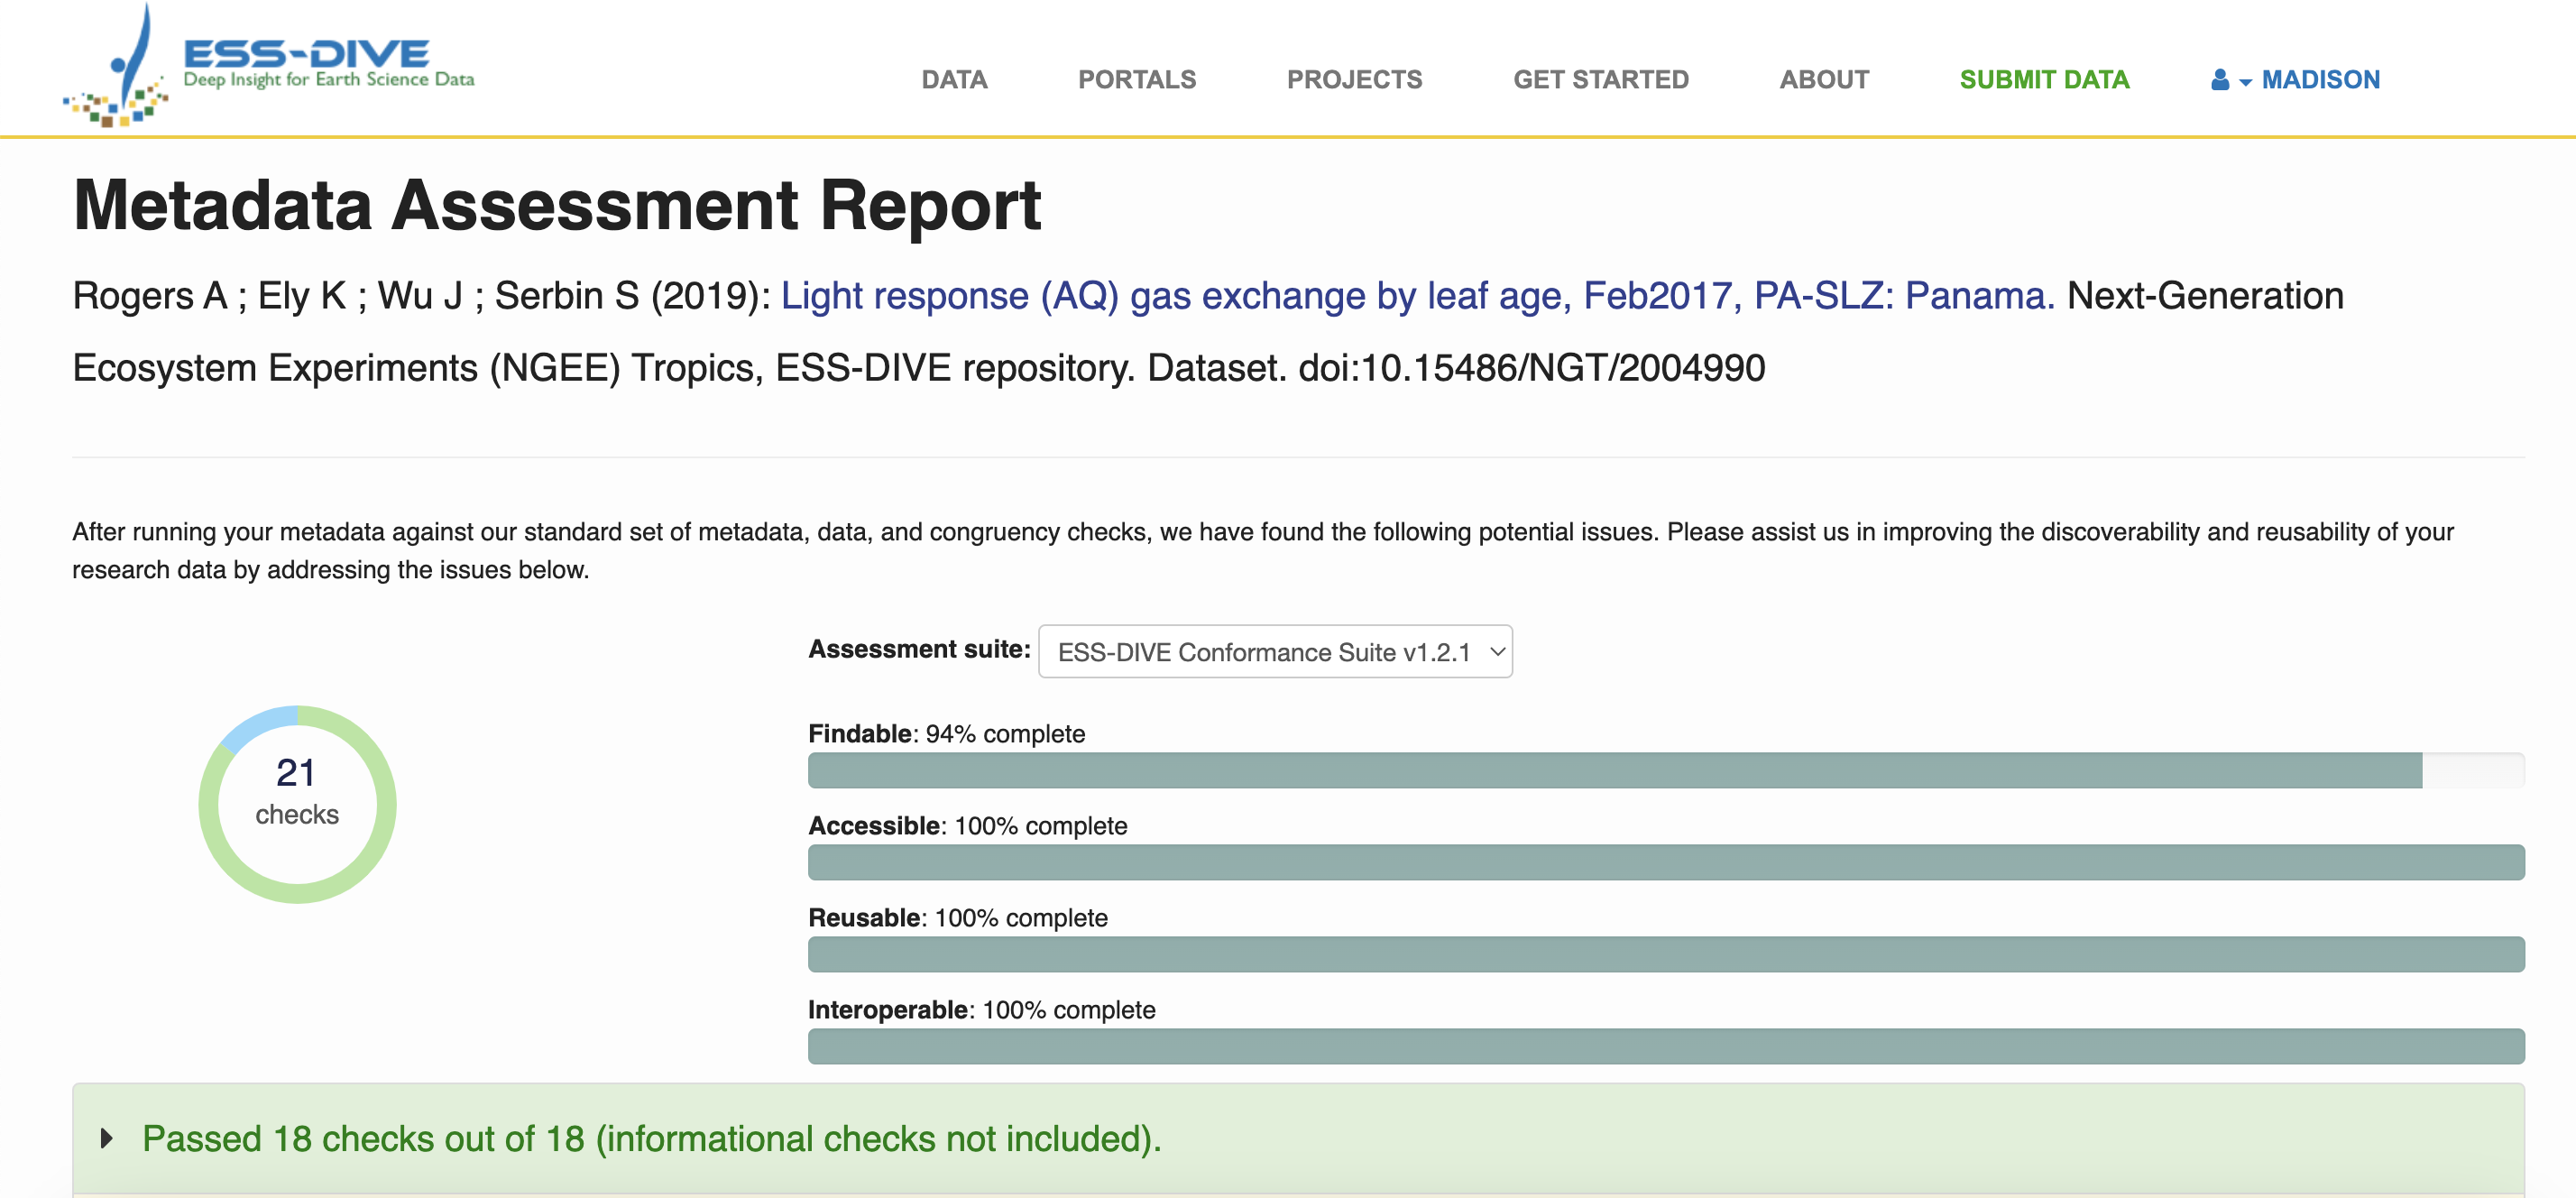
</div>


### **! Allow about 30 seconds for this cell to run, depending on number of project datasets**

In [ ]:
project_assessment_report = request_fair(public_datasets['ESS-DIVE ID'])

# View all assessment report results
display(project_assessment_report)

## Summary of Checks and Statuses
Every dataset undergoes 19 metadata quality checks

In [ ]:
display_html("<h3>Total Metadata Fields that Passed or Failed</h3>", raw=True)
display(project_assessment_report['Result'].value_counts())
display_html("<h3>Summary of Checks Passed and Failed</h3>", raw=True)
assessment_check_summary = project_assessment_report.groupby(['Check Name', 'Result']).size().unstack(fill_value=0)
display(assessment_check_summary)

## Export all FAIR Assessment Report Results

In [ ]:
# Change the name of your file by changing the sting here:
save_file('project_dataset_FAIR_results_example.csv',project_assessment_report)

# 6. Review Datasets with Failed Checks: Quickly identify areas of improvement
Projects may be interested in having 100% of their datasets pass the Assessment Report quality checks. A good starting point, is to quickly identify which datasets have failed checks to guage where to focus effort.
<br><br>
Here we demonstrate multiple ways to review the Assessment Report results.

In [ ]:
find_failed_checks = project_assessment_report[project_assessment_report['Result'] == 'FAILURE']

# View unique failed metadata checks and how many datasets had this result
display_html("<h3>Summarize unique failed checks</h3>", raw=True)
summary_failed_checks=pd.DataFrame({'Count':find_failed_checks.groupby(['Check Name']).size()})
display(summary_failed_checks)

# Provide a list of all datasets that have failed checks
display_html("<h3>Datasets to review</h3>", raw=True)
print("Number of Datasets to Review:", find_failed_checks['ESS-DIVE ID'].nunique())
summary_failed_datasets=pd.DataFrame({'Number of failed checks per dataset':find_failed_checks.groupby(['ESS-DIVE ID']).size().sort_values(ascending=False)})
display(summary_failed_datasets)

# View all failed metadata checks
display_html("<h3>List of all failed checks</h3>", raw=True)
display(find_failed_checks)

## Export report of failed quality checks for review

In [ ]:
# Change the name of your file by changing the sting here:
save_file('project_dataset_FAIR_results_FAILED_example.csv',find_failed_checks)